# Import and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


import pandas
import h5py
import pickle

import datetime

2022-09-20 14:20:45.678605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# configs
train, val, test = 0.6, 0.3, 0.1
Phi_sizes, F_sizes = (256, 256, 256), (256, 256, 256)
num_epoch = 500
batch_size = 1000

In [3]:
%cd /global/home/users/yifengh3/VAE/vec_data/signal

/global/home/users/yifengh3/VAE/vec_data/signal


In [4]:
%ls

B_signal_vector.h5        hv_vector_etadecay.h5
B_signal_vector_muons.h5  hv_vector.h5


# Load and Process Data

In [5]:
signal_1_df = "B_signal_vector.h5"
signal_2_df = "hv_vector.h5"
signal_1 = pandas.read_hdf(signal_1_df)
signal_2 = pandas.read_hdf(signal_2_df)

In [6]:
print("signal_1 data shape: {}".format(signal_1.shape))
print("signal_2 data shape: {}".format(signal_2.shape))

signal_1 data shape: (163600, 200)
signal_2 data shape: (33108, 200)


In [7]:
# assign labels to signal and background data, 0 for sig1,  1 for sig2
# (updated since we might get multiple signals) 
labeled_sig1 = np.append(signal_1,np.zeros((signal_1.shape[0],1)),axis=1)
labeled_sig2 = np.append(signal_2,np.ones((signal_2.shape[0],1)),axis=1)

In [8]:
# mix two data array into one signal array
data = np.concatenate((labeled_sig1,labeled_sig2))

#and shuffle the data
np.random.shuffle(data)

In [9]:
X = data[:,:-1]
y = data[:,-1]

In [10]:
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

shape of X: (196708, 200)
shape of Y: (196708,)


In [11]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = labeled_sig1.shape[0] + labeled_sig2.shape[0]
weight_for_0 = (1 / labeled_sig1.shape[0]) * (total / 2.0)
weight_for_1 = (1 / labeled_sig2.shape[0]) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for background: {:.2f}'.format(weight_for_0))
print('Weight for signal: {:.2f}'.format(weight_for_1))

Weight for background: 0.60
Weight for signal: 2.97


In [12]:
# To categorical as stipulated in example
Y = to_categorical(y, num_classes=2)

# Reshape X to shape (number of jets, 50, 4)
X = X.reshape(-1,50,4)

# ignore the pid info
X = X[:,:,:3]

In [13]:
print(X.shape)

(196708, 50, 3)


In [14]:
# normalizing jets
# copied from example
import tqdm
for x in tqdm.tqdm(X):
    # now add the status bar :)
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

100%|████████████████████████████████| 196708/196708 [00:11<00:00, 16712.74it/s]


In [15]:
print('Finished preprocessing')
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

Finished preprocessing
shape of X: (196708, 50, 3)
shape of Y: (196708,)


In [16]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

# Build and Train the Model

In [17]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model summary:


2022-09-20 14:21:00.852821: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-20 14:21:00.853905: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-20 14:21:00.883232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-09-20 14:21:00.883255: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-20 14:21:00.884568: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-20 14:21:00.884597: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 256)    1024        input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 256)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 256)    65792       activation[0][0]                 
______________________________________________________________________________________________

In [18]:
# now train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1**(1/5), patience=5, min_lr=1e-5,
                                                verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                              verbose=1)

callbacks = [reduce_lr,early_stop]

hist1 = pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1)

Epoch 1/500


2022-09-20 14:21:01.788605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-20 14:21:01.789049: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994530000 Hz
2022-09-20 14:21:02.185353: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


119/119 [==============================] - 2s 14ms/step - loss: 27.3511 - acc: 0.5300 - val_loss: 0.5441 - val_acc: 0.7408
Epoch 2/500
119/119 [==============================] - 1s 10ms/step - loss: 0.6347 - acc: 0.6842 - val_loss: 0.4328 - val_acc: 0.8508
Epoch 3/500
119/119 [==============================] - 1s 10ms/step - loss: 0.6835 - acc: 0.6821 - val_loss: 0.3423 - val_acc: 0.8725
Epoch 4/500
119/119 [==============================] - 1s 10ms/step - loss: 0.5853 - acc: 0.7109 - val_loss: 0.8760 - val_acc: 0.4683
Epoch 5/500
119/119 [==============================] - 1s 10ms/step - loss: 0.5986 - acc: 0.6993 - val_loss: 0.4444 - val_acc: 0.8349
Epoch 6/500
119/119 [==============================] - 1s 10ms/step - loss: 0.5245 - acc: 0.7574 - val_loss: 0.4134 - val_acc: 0.8325
Epoch 7/500
119/119 [==============================] - 1s 10ms/step - loss: 0.5020 - acc: 0.7730 - val_loss: 0.3258 - val_acc: 0.8734
Epoch 8/500
119/119 [==============================] - 1s 10ms/step - los

# Analyze the Model

In [19]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=10000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.9273957008985771



In [20]:
pred_1 = preds[:,1]

In [21]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=10000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,0], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,0], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.07260429910142287



/tmp/ipykernel_21775/3899958177.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(pfn_tp, 1/pfn_fp, '-', color='black', label='PFN')
/tmp/ipykernel_21775/3899958177.py:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(pfn_tp, 1/pfn_tp, '-', color='red', label='random')


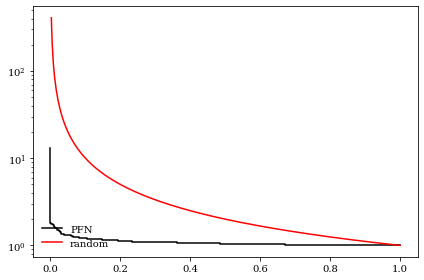

In [22]:
# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1/pfn_fp, '-', color='black', label='PFN')
plt.plot(pfn_tp, 1/pfn_tp, '-', color='red', label='random')
plt.yscale("log")
# plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
# plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
# plt.xlabel('Quark Jet Efficiency')
# plt.ylabel('Gluon Jet Rejection')

# axes limits
# plt.xlim(0, 1)
# plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()


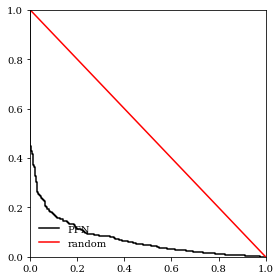

In [23]:
# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(pfn_tp, 1-pfn_tp, '-', color='red', label='random')
# plt.yscale("log")
# plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
# plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
# plt.xlabel('Quark Jet Efficiency')
# plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()


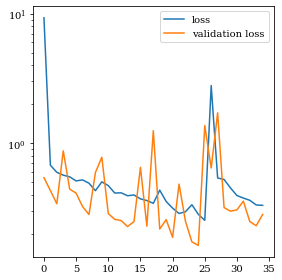

In [24]:
plt.plot(hist1.history["loss"],label="loss")
plt.plot(hist1.history["val_loss"],label="validation loss")
plt.legend()
plt.yscale("log")
plt.show()

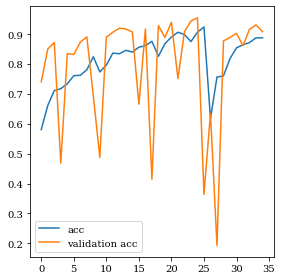

In [25]:
plt.plot(hist1.history["acc"],label="acc")
plt.plot(hist1.history["val_acc"],label="validation acc")
plt.legend()
plt.show()

In [26]:
Y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [27]:
preds[Y_test[:,1]==1].shape

(3339, 2)